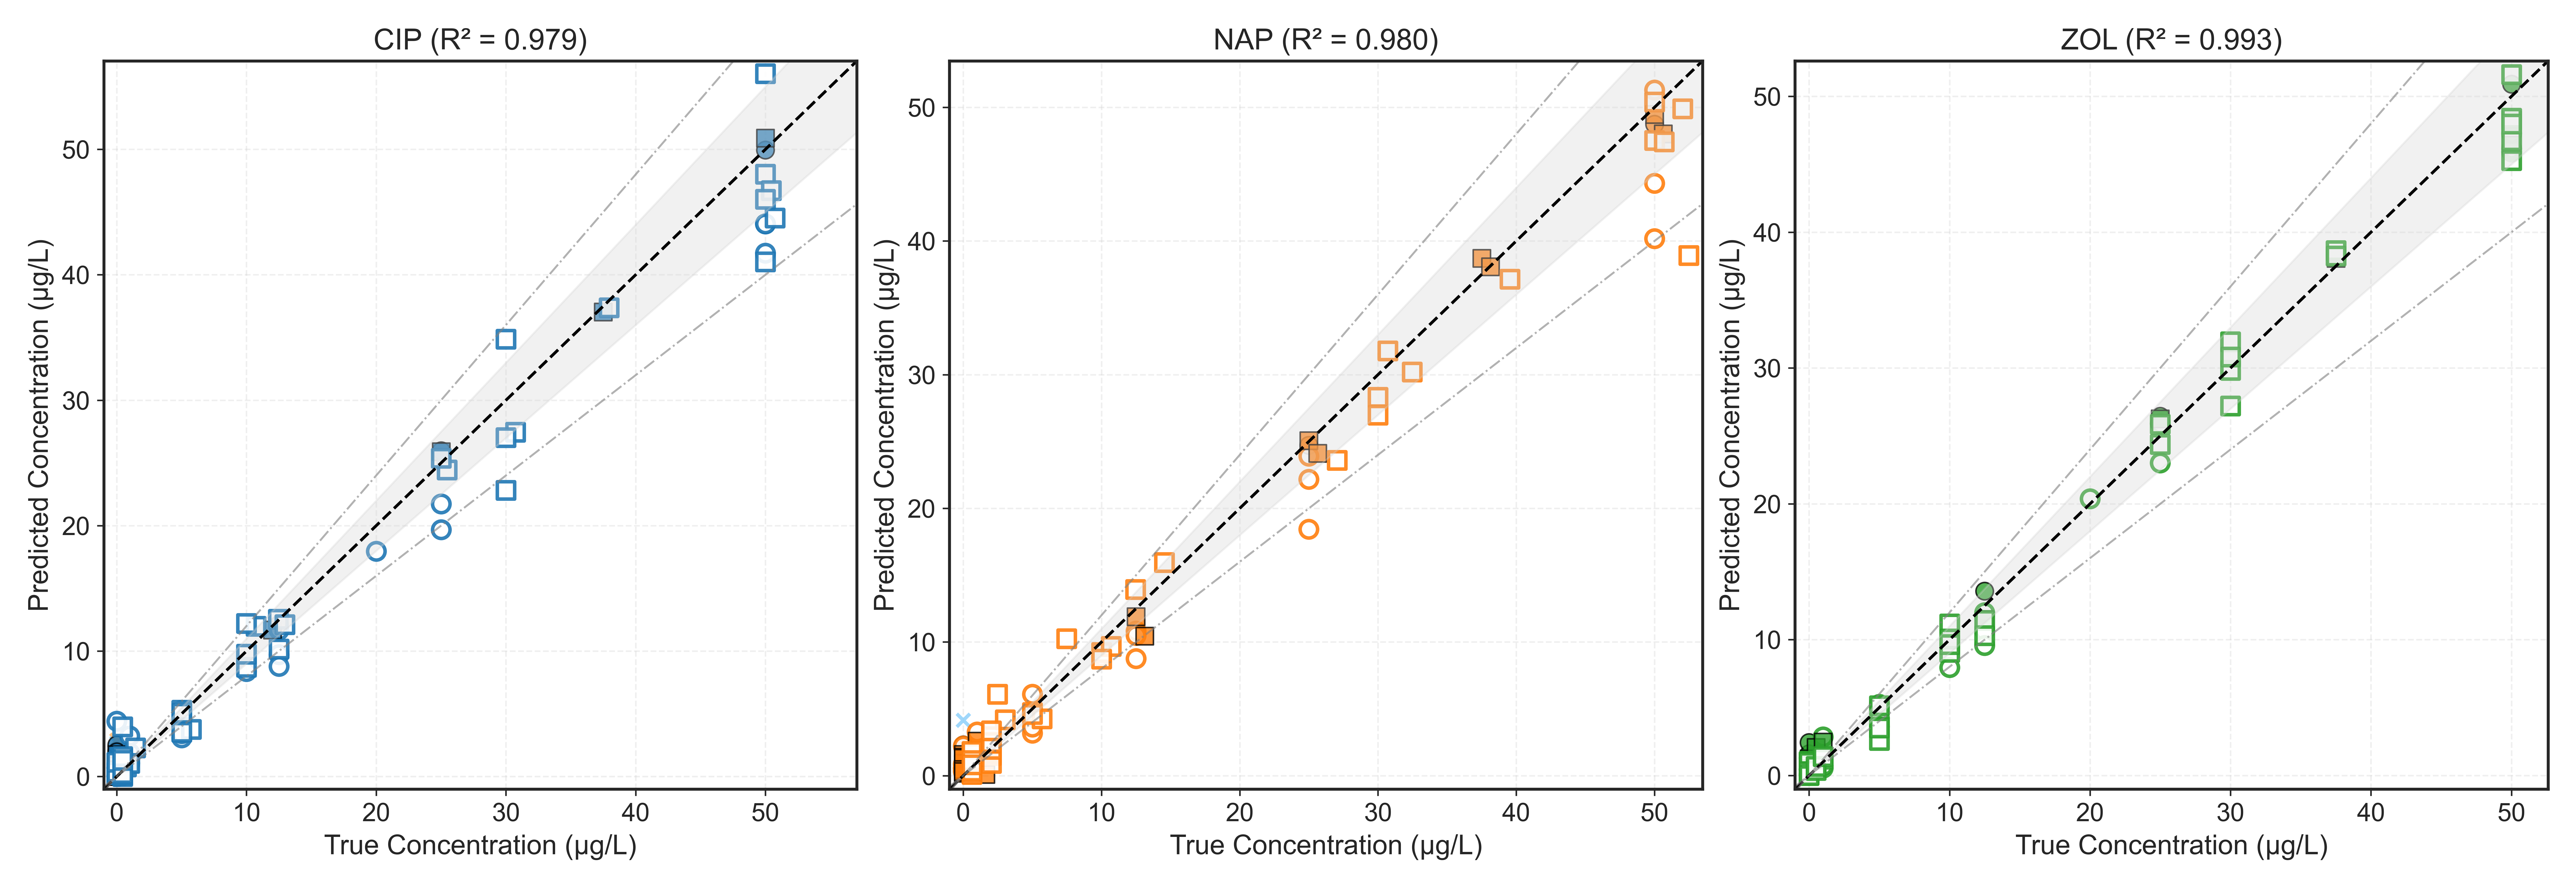

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D

# Set global seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configure plotting style
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
    'figure.dpi': 600,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2,
})
sns.set_style("ticks")

# 1. Load EEM data (replace NaN with 0)
def load_eem(filepath):
    try:
        df = pd.read_csv(filepath, index_col=0)
        eem = df.values.astype(np.float32)
        eem = np.nan_to_num(eem, nan=0.0)
        return eem
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# 2. Construct dataset from metadata and EEM files
def load_dataset(metadata_path, data_dir):
    meta = pd.read_csv(metadata_path, sep=";")
    X, y = [], []
    for _, row in meta.iterrows():
        sid = row["sample_identifier"]
        csv_path = os.path.join(data_dir, f"{sid}.csv")
        eem = load_eem(csv_path)
        if eem is None:
            continue
        X.append(eem)
        y.append([row["conc_cip"], row["conc_nap"], row["conc_zol"]])
    return np.array(X), np.array(y)

# Load natural water and wastewater datasets
X_nat, y_nat = load_dataset("Natural_water/metadata_natural_water.csv", "Natural_water")
X_wast, y_wast = load_dataset("Wastewater/metadata_wastewater.csv", "Wastewater")

# Create source labels: 0 = natural water (NW), 1 = wastewater (WW)
labels_nat = np.zeros(len(X_nat), dtype=int)
labels_wast = np.ones(len(X_wast), dtype=int)

# Merge datasets
X_raw = np.concatenate([X_nat, X_wast], axis=0)
y_raw = np.concatenate([y_nat, y_wast], axis=0)
source_labels = np.concatenate([labels_nat, labels_wast], axis=0)

n_samples, n_targets = X_raw.shape[0], y_raw.shape[1]

# ================================================================================
# Generate sample type labels (0=single OMPs, 1=mixture, 2=blank)
# ================================================================================
sample_type = np.zeros(n_samples, dtype=int)  # default to single
for i in range(n_samples):
    concs = y_raw[i]
    if np.all(concs == 0):
        sample_type[i] = 2  # blank (all zeros)
    elif np.sum(concs > 0) == 1:
        sample_type[i] = 0  # single OMPs (exactly one >0)
    else:
        sample_type[i] = 1  # mixture (two or three >0)

n_single = np.sum(sample_type == 0)
n_mixture = np.sum(sample_type == 1)
n_blank = np.sum(sample_type == 2)


# 3. Define CNN architecture for EEM spectral analysis
class EEMCNN(nn.Module):
    def __init__(self, num_targets=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((8, 8)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_targets)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

targets = ["CIP", "NAP", "ZOL"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# 4. Perform repeated stratified k-fold cross-validation
n_splits = 5
n_repeats = 5
rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_folds = n_splits * n_repeats
oof_predictions_raw = np.full((n_folds, n_samples, n_targets), np.nan)
fold_r2_scores = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X_raw, source_labels)):
    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y_raw[train_idx], y_raw[test_idx]


    X_min, X_max = X_train.min(), X_train.max()
    X_train_norm = (X_train - X_min) / (X_max - X_min + 1e-8)
    X_test_norm = (X_test - X_min) / (X_max - X_min + 1e-8)


    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)


    X_train_t = torch.tensor(X_train_norm[:, None, :, :], dtype=torch.float32)
    X_test_t = torch.tensor(X_test_norm[:, None, :, :], dtype=torch.float32)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=8, shuffle=True)


    model = EEMCNN(num_targets=n_targets).to(device)
    X_test_t = X_test_t.to(device)
    y_test_t = y_test_t.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    model.train()
    for epoch in range(120):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()

  
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_t).cpu().numpy()
        y_pred_orig = scaler_y.inverse_transform(y_pred_scaled)
        y_pred_orig = np.maximum(y_pred_orig, 0)
    
    r2_fold = [r2_score(y_test[:, i], y_pred_orig[:, i]) for i in range(n_targets)]
    fold_r2_scores.append(r2_fold)
    oof_predictions_raw[fold, test_idx, :] = y_pred_orig

oof_predictions = np.full((n_samples, n_targets), np.nan)
for i in range(n_samples):
    preds = oof_predictions_raw[:, i, :]
    valid = ~np.isnan(preds[:, 0])
    oof_predictions[i] = np.mean(preds[valid], axis=0)
oof_predictions = np.maximum(oof_predictions, 0)

overall_r2 = [r2_score(y_raw[:, i], oof_predictions[:, i]) for i in range(n_targets)]
mean_overall_r2 = np.mean(overall_r2)
fold_r2_scores = np.array(fold_r2_scores)
mean_fold_r2 = np.mean(fold_r2_scores, axis=0)
std_fold_r2 = np.std(fold_r2_scores, axis=0)

non_blank_mask = (sample_type != 2)
y_non_blank = y_raw[non_blank_mask]
oof_non_blank = oof_predictions[non_blank_mask]
source_non_blank = source_labels[non_blank_mask]
sample_type_non_blank = sample_type[non_blank_mask]

# 5. Generate Prediction vs. True plots with 4-way distinction (NW/WW × Single/Multiple)
# Generate prediction vs. true plots with 6-category visual encoding
#   ○ = natural water (NW), □ = wastewater (WW)
#   Solid fill = with one target OMP, open fill = Multiple ( with 2–3 target OMPs)
#   × = without target OMPs (light blue: NW matrix; light orange: WW matrix)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for i, (name, color) in enumerate(zip(targets, colors)):
    y_true = y_raw[:, i]
    y_pred = oof_predictions[:, i]
    ax = axes[i]
    
    # NW without OMPs: light blue cross (small size to reduce origin clutter)
    mask = (source_labels == 0) & (sample_type == 2)
    if np.any(mask):
        ax.scatter(y_true[mask], y_pred[mask],
                   marker='x', color='#87CEFA', s=45, alpha=0.8,
                   linewidths=1.8)
    
    # WW without OMPs: light orange cross
    mask = (source_labels == 1) & (sample_type == 2)
    if np.any(mask):
        ax.scatter(y_true[mask], y_pred[mask],
                   marker='x', color='#FFB366', s=45, alpha=0.8,
                   linewidths=1.8)
    
    # NW single: solid circle with black edge
    mask = (source_labels == 0) & (sample_type == 0)
    if np.any(mask):
        ax.scatter(y_true[mask], y_pred[mask],
                   marker='o', facecolors=color, edgecolors='k',
                   s=80, linewidths=0.8, alpha=0.8)
    
    # NW mixture: open circle with colored edge
    mask = (source_labels == 0) & (sample_type == 1)
    if np.any(mask):
        ax.scatter(y_true[mask], y_pred[mask],
                   marker='o', facecolors='white', edgecolors=color,
                   s=80, linewidths=1.8, alpha=0.9)
    
    # WW single: solid square with black edge
    mask = (source_labels == 1) & (sample_type == 0)
    if np.any(mask):
        ax.scatter(y_true[mask], y_pred[mask],
                   marker='s', facecolors=color, edgecolors='k',
                   s=80, linewidths=0.8, alpha=0.8)
    
    # WW mixture: open square with colored edge
    mask = (source_labels == 1) & (sample_type == 1)
    if np.any(mask):
        ax.scatter(y_true[mask], y_pred[mask],
                   marker='s', facecolors='white', edgecolors=color,
                   s=80, linewidths=1.8, alpha=0.9)
    
    # Reference lines
    lims = [min(y_true.min(), y_pred.min()) - 1, max(y_true.max(), y_pred.max()) + 1]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, 'k--', linewidth=1.5)
    x_line = np.linspace(lims[0], lims[1], 200)
    ax.fill_between(x_line, 0.9 * x_line, 1.1 * x_line, color='lightgray', alpha=0.3)
    ax.plot(x_line, 1.2 * x_line, 'gray', linestyle='-.', linewidth=1.0, alpha=0.6)
    ax.plot(x_line, 0.8 * x_line, 'gray', linestyle='-.', linewidth=1.0, alpha=0.6)
    
    ax.set_xlabel('True Concentration (μg/L)')
    ax.set_ylabel('Predicted Concentration (μg/L)')
    ax.set_title(f'{name} (R² = {overall_r2[i]:.3f})')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.savefig("prediction_vs_true_cv_g.pdf", dpi=600)
plt.savefig("prediction_vs_true_cv_g.png", dpi=600)
plt.show()
